In [ ]:
import os
from pathlib import Path
import math
import time

import numpy as np
import nibabel as nib

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import matplotlib.pyplot as plt

DATASET_ROOT = Path("../dataset")

IMAGE_SIZE = 128
BATCH_SIZE = 8
NUM_WORKERS = 0
NUM_EPOCHS = 20
TIMESTEPS = 1000
LEARNING_RATE = 2e-4

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Using device:", device)


Using device: mps


In [ ]:
class BraTSSliceDataset(Dataset):
    """
    Simple dataset:
    - Finds all *flair.nii.gz files
    - Uses central 80% slices from each volume
    - Returns normalized 2D slice as tensor in [-1, 1], shape (1, H, W)
    """
    def __init__(self, root_dir, modality_suffix="_flair.nii.gz", image_size=128):
        super().__init__()
        self.root_dir = Path(root_dir)
        self.image_size = image_size
        self.modality_suffix = modality_suffix

        self.volume_paths = sorted(self.root_dir.rglob(f"*{modality_suffix}"))
        if not self.volume_paths:
            raise RuntimeError(f"No FLAIR files (*{modality_suffix}) found under {root_dir}")

        # Build (path, slice_index) list without loading data
        self.slice_tuples = []
        for p in self.volume_paths:
            img = nib.load(str(p))
            shape = img.shape  # (H, W, D)
            if len(shape) != 3:
                continue
            H, W, D = shape
            z_start = int(0.1 * D)
            z_end   = int(0.9 * D)
            for z in range(z_start, z_end):
                self.slice_tuples.append((p, z))

        print(f"Found {len(self.volume_paths)} volumes.")
        print(f"Built {len(self.slice_tuples)} (volume, slice) pairs.")

    def __len__(self):
        return len(self.slice_tuples)

    def __getitem__(self, idx):
        path, z = self.slice_tuples[idx]

        img = nib.load(str(path))
        vol = np.asanyarray(img.dataobj)  # shape: (H, W, D)
        slice_2d = vol[:, :, z].astype(np.float32)

        # Normalize using non-zero voxels
        mask = slice_2d != 0
        if np.any(mask):
            mean = slice_2d[mask].mean()
            std = slice_2d[mask].std()
            std = std if std > 0 else 1.0
            slice_2d[mask] = (slice_2d[mask] - mean) / std

        # Clip extreme values and map to [0,1]
        slice_2d = np.clip(slice_2d, -5, 5)
        slice_2d = (slice_2d + 5) / 10.0  # now in [0,1]

        # To tensor and resize to (image_size, image_size)
        slice_t = torch.from_numpy(slice_2d).unsqueeze(0).unsqueeze(0)  # (1,1,H,W)
        slice_t = F.interpolate(
            slice_t,
            size=(self.image_size, self.image_size),
            mode="bilinear",
            align_corners=False,
        )
        slice_t = slice_t.squeeze(0)  # (1,H,W)

        # Map [0,1] -> [-1,1]
        slice_t = slice_t * 2.0 - 1.0

        return slice_t

full_dataset = BraTSSliceDataset(DATASET_ROOT, image_size=IMAGE_SIZE)

train_size = int(0.9 * len(full_dataset))
val_size   = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

print(f"Train slices: {len(train_dataset)}, Val slices: {len(val_dataset)}")


Found 1251 volumes.
Built 155124 (volume, slice) pairs.
Train slices: 139611, Val slices: 15513


Batch shape: torch.Size([8, 1, 128, 128])


/Users/I568853/GitHub/UNI/KIT/mri/env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


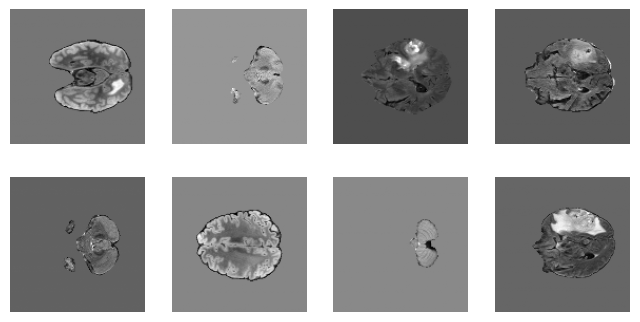

In [ ]:
batch = next(iter(train_loader))
print("Batch shape:", batch.shape)

def show_grid(imgs, rows=2, cols=4):
    plt.figure(figsize=(cols*2, rows*2))
    for i in range(rows*cols):
        if i >= imgs.shape[0]:
            break
        plt.subplot(rows, cols, i+1)
        img = (imgs[i, 0].cpu().numpy() + 1.0) / 2.0
        plt.imshow(img, cmap="gray")
        plt.axis("off")
    plt.show()

show_grid(batch, rows=2, cols=4)


In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F


class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim: int):
        super().__init__()
        self.dim = dim

    def forward(self, t: torch.Tensor) -> torch.Tensor:
        """
        t: (B,) integer timesteps
        returns: (B, dim) sinusoidal embedding
        """
        device = t.device
        half_dim = self.dim // 2
        emb_factor = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb_factor)
        emb = t.float().unsqueeze(1) * emb.unsqueeze(0)  # (B, half_dim)
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)
        if self.dim % 2 == 1:
            emb = F.pad(emb, (0, 1))
        return emb


class ResidualBlock(nn.Module):
    def __init__(self, in_ch: int, out_ch: int, t_dim: int, groups: int = 8):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)

        self.time_mlp = nn.Linear(t_dim, out_ch)

        self.norm1 = nn.GroupNorm(groups, out_ch)
        self.norm2 = nn.GroupNorm(groups, out_ch)
        self.act = nn.SiLU()

        self.res_conv = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x: torch.Tensor, t_emb: torch.Tensor) -> torch.Tensor:
        h = self.conv1(x)
        h = self.norm1(h)
        h = self.act(h)

        # time embedding
        t = self.time_mlp(t_emb)
        t = self.act(t)
        h = h + t[:, :, None, None]

        h = self.conv2(h)
        h = self.norm2(h)
        h = self.act(h)

        return h + self.res_conv(x)


class DownBlock(nn.Module):
    """
    One U-Net down block:
      in_ch -> out_ch (same spatial size)
      then downsample to half spatial size
    Returns (x_down, skip)
    """
    def __init__(self, in_ch: int, out_ch: int, t_dim: int):
        super().__init__()
        self.res1 = ResidualBlock(in_ch, out_ch, t_dim)
        self.res2 = ResidualBlock(out_ch, out_ch, t_dim)
        self.down = nn.Conv2d(out_ch, out_ch, 4, stride=2, padding=1)

    def forward(self, x: torch.Tensor, t_emb: torch.Tensor):
        x = self.res1(x, t_emb)
        x = self.res2(x, t_emb)
        skip = x
        x = self.down(x)
        return x, skip


class UpBlock(nn.Module):
    """
    One U-Net up block:
      upsample x (in_ch -> out_ch, double spatial size),
      concat with skip (skip_ch),
      then two residual blocks -> out_ch
    """
    def __init__(self, in_ch: int, skip_ch: int, out_ch: int, t_dim: int):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, out_ch, 4, stride=2, padding=1)
        self.res1 = ResidualBlock(out_ch + skip_ch, out_ch, t_dim)
        self.res2 = ResidualBlock(out_ch, out_ch, t_dim)

    def forward(self, x: torch.Tensor, skip: torch.Tensor, t_emb: torch.Tensor) -> torch.Tensor:
        x = self.up(x)

        if x.shape[-2:] != skip.shape[-2:]:
            x = F.interpolate(x, size=skip.shape[-2:], mode="bilinear", align_corners=False)

        x = torch.cat([x, skip], dim=1)

        x = self.res1(x, t_emb)
        x = self.res2(x, t_emb)
        return x


class UNet(nn.Module):
    """
    Time-conditioned U-Net used inside the DDPM.
    Works for 1-channel 2D MRI slices (e.g. 128x128).
    """

    def __init__(
        self,
        img_channels: int = 1,
        base_channels: int = 64,
        channel_mults=(1, 2, 4, 8),
        time_emb_dim: int = 256,
    ):
        super().__init__()

        # ----- time embedding -----
        self.time_mlp = nn.Sequential(
            SinusoidalPosEmb(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim * 4),
            nn.SiLU(),
            nn.Linear(time_emb_dim * 4, time_emb_dim),
        )

        # channel sizes at each resolution
        self.chs = [base_channels * m for m in channel_mults]

        # initial conv: (img_channels -> chs[0])
        self.init_conv = nn.Conv2d(img_channels, self.chs[0], 3, padding=1)

        # ----- down path -----
        downs = []
        for in_ch, out_ch in zip(self.chs[:-1], self.chs[1:]):
            downs.append(DownBlock(in_ch, out_ch, time_emb_dim))
        self.downs = nn.ModuleList(downs)

        # bottleneck
        self.mid_block1 = ResidualBlock(self.chs[-1], self.chs[-1], time_emb_dim)
        self.mid_block2 = ResidualBlock(self.chs[-1], self.chs[-1], time_emb_dim)

        # ----- up path -----
        ups = []
        # skips have channels [chs[1], chs[2], ..., chs[-1]]
        skip_chs = self.chs[1:]
        in_ch = self.chs[-1]
        # reverse to go from coarsest to finest
        for skip_ch, out_ch in zip(reversed(skip_chs), reversed(self.chs[:-1])):
            ups.append(UpBlock(in_ch, skip_ch, out_ch, time_emb_dim))
            in_ch = out_ch
        self.ups = nn.ModuleList(ups)

        # final conv
        self.out_norm = nn.GroupNorm(8, self.chs[0])
        self.out_conv = nn.Conv2d(self.chs[0], img_channels, 3, padding=1)

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        x: (B, C, H, W) in [-1, 1]
        t: (B,) integer timesteps
        """
        t_emb = self.time_mlp(t)

        x = self.init_conv(x)

        # store skips
        skips = []
        for down in self.downs:
            x, skip = down(x, t_emb)
            skips.append(skip)

        # bottleneck
        x = self.mid_block1(x, t_emb)
        x = self.mid_block2(x, t_emb)

        # up path
        for up in self.ups:
            skip = skips.pop()
            x = up(x, skip, t_emb)

        x = self.out_norm(x)
        x = F.silu(x)
        x = self.out_conv(x)
        return x


In [11]:
model = UNet(
    img_channels=1,
    base_channels=64,
    channel_mults=(1, 2, 4, 8),
    time_emb_dim=256,
).to(device)


In [ ]:
class GaussianDiffusion(nn.Module):
    def __init__(
        self,
        model,
        image_size,
        channels=1,
        timesteps=1000,
        beta_start=1e-4,
        beta_end=0.02,
    ):
        super().__init__()
        self.model = model
        self.image_size = image_size
        self.channels = channels
        self.timesteps = timesteps

        betas = torch.linspace(beta_start, beta_end, timesteps, dtype=torch.float32)
        alphas = 1.0 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)
        alphas_cumprod_prev = torch.cat(
            [torch.tensor([1.0], dtype=torch.float32), alphas_cumprod[:-1]], dim=0
        )

        self.register_buffer("betas", betas)
        self.register_buffer("alphas", alphas)
        self.register_buffer("alphas_cumprod", alphas_cumprod)
        self.register_buffer("alphas_cumprod_prev", alphas_cumprod_prev)
        self.register_buffer("sqrt_alphas_cumprod", torch.sqrt(alphas_cumprod))
        self.register_buffer(
            "sqrt_one_minus_alphas_cumprod", torch.sqrt(1.0 - alphas_cumprod)
        )
        self.register_buffer("sqrt_recip_alphas", torch.sqrt(1.0 / alphas))

        # Posterior variance (Eq. 7 in DDPM paper)
        posterior_variance = (
            betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)
        )
        self.register_buffer("posterior_variance", posterior_variance)
        self.register_buffer(
            "posterior_log_variance_clipped",
            torch.log(torch.clamp(posterior_variance, min=1e-20)),
        )

    def _extract(self, a, t, x_shape):
        """
        Extract values for batch of indices t, shape (B,) from a tensor a of shape (T,)
        and reshape to (B, 1, 1, 1) for broadcasting.
        """
        B = t.shape[0]
        out = a.gather(-1, t)
        return out.view(B, 1, 1, 1).expand(x_shape)

    def q_sample(self, x_start, t, noise=None):
        """
        Sample from q(x_t | x_0).
        x_start: (B, C, H, W) in [-1, 1]
        t: (B,) integer timesteps
        """
        if noise is None:
            noise = torch.randn_like(x_start)

        sqrt_alphas_cumprod_t = self._extract(
            self.sqrt_alphas_cumprod, t, x_start.shape
        )
        sqrt_one_minus_alphas_cumprod_t = self._extract(
            self.sqrt_one_minus_alphas_cumprod, t, x_start.shape
        )
        return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

    def p_losses(self, x_start, t, noise=None):
        """
        Loss for a given batch.
        Predicts the noise and uses MSE between true noise and predicted noise.
        """
        if noise is None:
            noise = torch.randn_like(x_start)

        x_noisy = self.q_sample(x_start=x_start, t=t, noise=noise)
        predicted_noise = self.model(x_noisy, t)

        return F.mse_loss(predicted_noise, noise)

    @torch.no_grad()
    def p_sample(self, x, t):
        """
        One reverse diffusion step: p(x_{t-1} | x_t).
        """
        betas_t = self._extract(self.betas, t, x.shape)
        sqrt_one_minus_alphas_cumprod_t = self._extract(
            self.sqrt_one_minus_alphas_cumprod, t, x.shape
        )
        sqrt_recip_alphas_t = self._extract(self.sqrt_recip_alphas, t, x.shape)
        posterior_variance_t = self._extract(self.posterior_variance, t, x.shape)

        # Predict noise
        eps_theta = self.model(x, t)

        model_mean = sqrt_recip_alphas_t * (
            x - betas_t / sqrt_one_minus_alphas_cumprod_t * eps_theta
        )

        noise = torch.randn_like(x)
        nonzero_mask = (t != 0).float().view(-1, 1, 1, 1)  # 0 at t=0, 1 otherwise

        return model_mean + nonzero_mask * torch.sqrt(posterior_variance_t) * noise

    @torch.no_grad()
    def p_sample_loop(self, shape):
        """
        Generate a full sample starting from x_T ~ N(0, I).
        """
        device = self.betas.device
        B = shape[0]
        img = torch.randn(shape, device=device)

        for i in reversed(range(self.timesteps)):
            t = torch.full((B,), i, device=device, dtype=torch.long)
            img = self.p_sample(img, t)

        return img

    @torch.no_grad()
    def sample(self, batch_size=16):
        return self.p_sample_loop(
            (batch_size, self.channels, self.image_size, self.image_size)
        )


In [7]:
diffusion = GaussianDiffusion(
    model=model,
    image_size=IMAGE_SIZE,
    channels=1,
    timesteps=TIMESTEPS,
).to(device)

In [8]:
diffusion.train()

x = next(iter(train_loader)).to(device)
t = torch.randint(0, diffusion.timesteps, (x.size(0),), device=device).long()

print("Running one forward+backward step...")
loss = diffusion.p_losses(x, t)
loss.backward()
print("Done. Loss:", loss.item())

Running one forward+backward step...
Done. Loss: 1.2047302722930908


In [ ]:
optimizer = torch.optim.Adam(diffusion.model.parameters(), lr=LEARNING_RATE)

def train_one_epoch(epoch):
    diffusion.train()
    running_loss = 0.0
    n_steps = 0

    for step, x in enumerate(train_loader, start=1):
        x = x.to(device)

        t = torch.randint(0, diffusion.timesteps, (x.size(0),), device=device).long()

        loss = diffusion.p_losses(x, t)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        n_steps += 1
        if step % 500 == 0:
            avg = running_loss / n_steps
            print(f"[epoch {epoch} | step {step}] avg loss: {avg:.4f}")

    avg_loss = running_loss / max(1, n_steps)
    print(f"Epoch {epoch} | Train loss: {avg_loss:.4f}")
    return avg_loss

@torch.no_grad()
def validate(epoch):
    diffusion.eval()
    running_loss = 0.0
    n_steps = 0

    for x in val_loader:
        x = x.to(device)
        t = torch.randint(0, diffusion.timesteps, (x.size(0),), device=device).long()
        loss = diffusion.p_losses(x, t)
        running_loss += loss.item()
        n_steps += 1

    avg_loss = running_loss / max(1, n_steps)
    print(f"Epoch {epoch} | Val loss:   {avg_loss:.4f}")
    return avg_loss


@torch.no_grad()
def sample_and_show(epoch, num_samples=8):
    diffusion.eval()
    samples = diffusion.sample(batch_size=num_samples)
    samples = samples.clamp(-1, 1)
    samples = (samples + 1.0) / 2.0

    samples = samples.cpu()

    cols = 4
    rows = int(math.ceil(num_samples / cols))
    plt.figure(figsize=(cols * 2, rows * 2))
    for i in range(num_samples):
        plt.subplot(rows, cols, i + 1)
        img = samples[i, 0].numpy()
        plt.imshow(img, cmap="gray")
        plt.axis("off")
    plt.suptitle(f"DDPM samples after epoch {epoch}")
    plt.show()


print("Starting Training")
best_val = float("inf")

for epoch in range(1, NUM_EPOCHS + 1):
    start_time = time.time()

    train_loss = train_one_epoch(epoch)
    val_loss = validate(epoch)

    if val_loss < best_val:
        best_val = val_loss
        torch.save(
            diffusion.state_dict(),
            f"ddpm_braTS_flair_best.pt",
        )
        print("  -> Saved new best model.")

    if epoch == NUM_EPOCHS:
        sample_and_show(epoch, num_samples=8)

    print(f"Epoch {epoch} done in {(time.time() - start_time):.1f}s\n")

Starting Training


/Users/I568853/GitHub/UNI/KIT/mri/env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[epoch 1 | step 500] avg loss: 0.0256
[epoch 1 | step 1000] avg loss: 0.0192
[epoch 1 | step 1500] avg loss: 0.0165
[epoch 1 | step 2000] avg loss: 0.0151
[epoch 1 | step 2500] avg loss: 0.0141
[epoch 1 | step 3000] avg loss: 0.0133
[epoch 1 | step 3500] avg loss: 0.0128
[epoch 1 | step 4000] avg loss: 0.0125
[epoch 1 | step 4500] avg loss: 0.0120
[epoch 1 | step 5000] avg loss: 0.0117
[epoch 1 | step 5500] avg loss: 0.0116
[epoch 1 | step 6000] avg loss: 0.0114
[epoch 1 | step 6500] avg loss: 0.0112
[epoch 1 | step 7000] avg loss: 0.0110
[epoch 1 | step 7500] avg loss: 0.0109
[epoch 1 | step 8000] avg loss: 0.0107
[epoch 1 | step 8500] avg loss: 0.0106
[epoch 1 | step 9000] avg loss: 0.0105
[epoch 1 | step 9500] avg loss: 0.0104
[epoch 1 | step 10000] avg loss: 0.0103
[epoch 1 | step 10500] avg loss: 0.0102
[epoch 1 | step 11000] avg loss: 0.0101
[epoch 1 | step 11500] avg loss: 0.0100
[epoch 1 | step 12000] avg loss: 0.0100
[epoch 1 | step 12500] avg loss: 0.0099
[epoch 1 | step 1300

KeyboardInterrupt: 

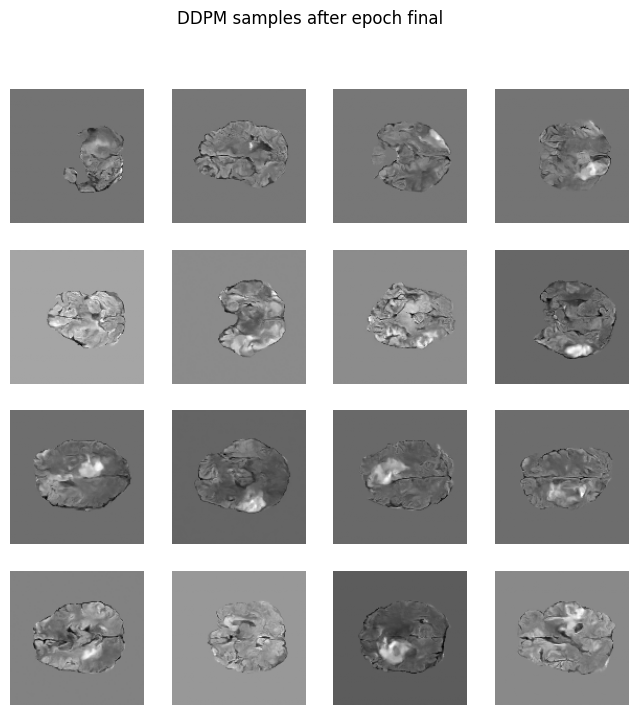

In [ ]:
checkpoint_path = "ddpm_braTS_flair_best.pt"
state = torch.load(checkpoint_path, map_location=device)
diffusion.load_state_dict(state)
diffusion.to(device)

sample_and_show(epoch="final", num_samples=16)
